In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from sklearn import preprocessing
from collections import Counter
import glob
from scipy import stats

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

In [1]:
from utils import *
# sys.path.append(r"A:\US_CornSoy_ClassificationYield\Scripts\US_CornSoy_ClassificationYield")
# from utils import *

In [ ]:
from importlib import reload
reload(sys.modules['utils'])
from utils import *

# Read data

In [8]:
# Shapefiles
path_csb22 = r"A:\US_CornSoy_ClassificationYield\Geodata\Vectors\csb_IA_2022.shp"
csb22 = gpd.read_file(path_csb22)

In [11]:
dir_usda = r"D:\US_CornSoy_ClassificationYield\TabularData"
usda_area = pd.read_csv(os.path.join(dir_usda, "US_County_CornSoy_Area.csv"))

# Preprocess

## USDA Area

In [12]:
state_area = usda_area[usda_area['Geo Level'] == 'STATE']
cnty_area = usda_area[usda_area['Geo Level'] == 'COUNTY']
#SUBSET COLUMNS
state_area = state_area[['Year', 'State', 'State ANSI', 'Commodity', 'Value']]
cnty_area = cnty_area[['Year', 'State', 'State ANSI', 'County', 'County ANSI', 'Commodity', 'Value']]
#Rename Columns
state_area.columns = ['Year', 'State', 'StateANSI', 'Crop', 'AreaAcres_usda']
cnty_area.columns = ['Year', 'State', 'StateANSI', 'County', 'CntyANSI', 'Crop', 'AreaAcres_usda']
#remove rows whose CntyANSI column is NaN
cnty_area = cnty_area.dropna(subset=['CntyANSI']) 
#convert CntyANSI to int with no decimal, and fill with leading zeros to make 3 digits
cnty_area['CntyANSI'] = cnty_area['CntyANSI'].astype(int).astype(str).str.zfill(3)
#convert State and County and Crop column to be uppercase for only the first letter
cnty_area['State'] = cnty_area['State'].str.title()
cnty_area['County'] = cnty_area['County'].str.title()
cnty_area['Crop'] = cnty_area['Crop'].str.title()
state_area['State'] = state_area['State'].str.title()
state_area['Crop'] = state_area['Crop'].str.title()
#remove comma in AreaAcres_usda column, and convert AreaAcres_usda to float
cnty_area['AreaAcres_usda'] = cnty_area['AreaAcres_usda'].str.replace(',', '').astype(float)
state_area['AreaAcres_usda'] = state_area['AreaAcres_usda'].str.replace(',', '').astype(float)
#convert Soybeans to Soybean
cnty_area['Crop'] = cnty_area['Crop'].str.replace('Soybeans', 'Soybean')
state_area['Crop'] = state_area['Crop'].str.replace('Soybeans', 'Soybean')

## CSB data

In [13]:
#subset columns 
csb22 = csb22[['CSBID','CSBACRES','R15', 'R16', 'R17', 'R18', 'R19','R20', 'R21', 'R22', 'CNTY','CNTYFIPS', 'STATEASD']]
#set CNTYFIPS to string
csb22['CNTYFIPS'] = csb22['CNTYFIPS'].astype(str)
csb22['STATEASD'] = csb22['STATEASD'].astype(str)
csb22.head()
# reclassify R15-R22 to three classes 
def tri_classes(value):
    if value == 1:
        return 'Corn'
    elif value == 5:
        return 'Soybean'
    else:
        return 'Other'
csb22[['R15', 'R16', 'R17', 'R18', 'R19','R20', 'R21', 'R22']] = csb22[['R15', 'R16', 'R17', 'R18', 'R19','R20', 'R21', 'R22']].applymap(tri_classes)

In [15]:
print(csb22.shape)
print(Counter(csb22['R22']).most_common(5))
print(Counter(csb22['R21']).most_common(5))
print(Counter(csb22['R20']).most_common(5))
print(Counter(csb22['R19']).most_common(5))
print(Counter(csb22['R18']).most_common(5))
print(Counter(csb22['R17']).most_common(5))
print(Counter(csb22['R16']).most_common(5))
print(Counter(csb22['R15']).most_common(5))

(700921, 13)
[('Corn', 302231), ('Soybean', 236230), ('Other', 162460)]
[('Corn', 307580), ('Soybean', 236669), ('Other', 156672)]
[('Corn', 337780), ('Soybean', 224804), ('Other', 138337)]
[('Corn', 330933), ('Soybean', 211128), ('Other', 158860)]
[('Corn', 321967), ('Soybean', 230429), ('Other', 148525)]
[('Corn', 327317), ('Soybean', 229726), ('Other', 143878)]
[('Corn', 330750), ('Soybean', 213951), ('Other', 156220)]
[('Corn', 311700), ('Soybean', 217982), ('Other', 171239)]


## Compare with USDA Area 

- Need to change state name in plots when copying the code to different states

In [16]:
agg_corn22_cnty = csb22[csb22['R22'] == 'Corn'].groupby(['CNTYFIPS', 'CNTY']).agg({'CSBACRES':'sum'}).reset_index()
agg_soy22_cnty = csb22[csb22['R22'] == 'Soybean'].groupby(['CNTYFIPS', 'CNTY']).agg({'CSBACRES':'sum'}).reset_index()
agg_corn22_cnty.head()

,CNTYFIPS,CNTY,CSBACRES
0,001,Adair,118404.849824
1,003,Adams,72194.401295
2,005,Allamakee,70733.373501
3,007,Appanoose,28495.766937
4,009,Audubon,118455.990340


In [17]:
# Need to change the state name 
compare_corn22_cnty = pd.merge(agg_corn22_cnty, cnty_area[(cnty_area.Crop == 'Corn')&(cnty_area.Year==2022)&(cnty_area.State=='Iowa')], how = "inner", left_on=['CNTYFIPS','CNTY'], right_on=['CntyANSI','County'])
compare_soy22_cnty = pd.merge(agg_soy22_cnty, cnty_area[(cnty_area.Crop == 'Soybean')&(cnty_area.Year==2022)&(cnty_area.State=='Iowa')], how = "inner", left_on=['CNTYFIPS','CNTY'], right_on=['CntyANSI','County'])

r2 (corn)=  0.9945654472614522
Total area of corn in CSB =  12803457.00978917
Total area of corn in USDA =  12632600.0
Diffrence of total area of corn in CSB and USDA =  170857.0097891707
Percentage of total area of corn in CSB and USDA =  0.013525086663804023
r2 (soybean)=  0.9948652384405954
Total area of soybean in CSB =  10010472.64538408
Total area of soybean in USDA =  9814700.0
Diffrence of total area of soybean in CSB and USDA =  195772.6453840807
Percentage of total area of soybean in CSB and USDA =  0.019946880229052413


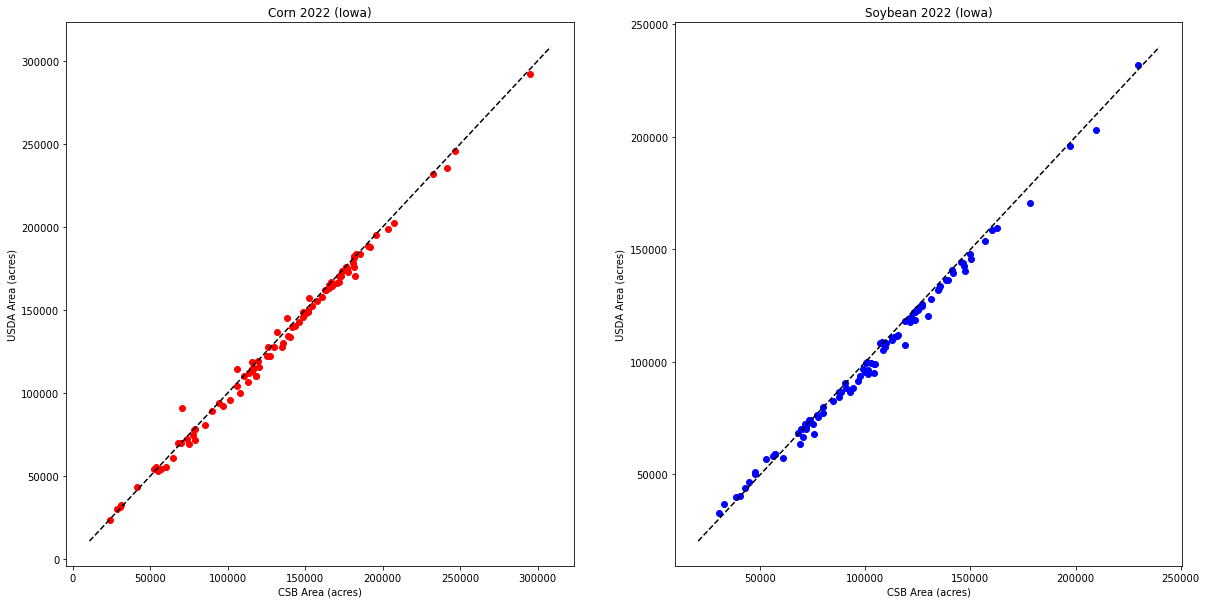

In [18]:
# Plot the comparison of CSBACRES and AreaAcres_usda for corn and soybean in two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.scatter(compare_corn22_cnty['CSBACRES'], compare_corn22_cnty['AreaAcres_usda'], color='red')
ax1.set_title('Corn 2022 (Iowa)')
ax1.set_xlabel('CSB Area (acres)')
ax1.set_ylabel('USDA Area (acres)')
#add 1:1 line
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, color='black', linestyle='--')
#calculate and print out the r2
r2 = np.corrcoef(compare_corn22_cnty['CSBACRES'], compare_corn22_cnty['AreaAcres_usda'])[0,1]**2
print('r2 (corn)= ', r2)
#Calculate the total area of corn in CSB and USDA
print('Total area of corn in CSB = ', compare_corn22_cnty['CSBACRES'].sum())
print('Total area of corn in USDA = ', compare_corn22_cnty['AreaAcres_usda'].sum())
#Calculate the diffrence and percentage of the total area of corn in CSB and USDA
print('Diffrence of total area of corn in CSB and USDA = ', compare_corn22_cnty['CSBACRES'].sum() - compare_corn22_cnty['AreaAcres_usda'].sum())
print('Percentage of total area of corn in CSB and USDA = ', (compare_corn22_cnty['CSBACRES'].sum() - compare_corn22_cnty['AreaAcres_usda'].sum())/compare_corn22_cnty['AreaAcres_usda'].sum())

ax2.scatter(compare_soy22_cnty['CSBACRES'], compare_soy22_cnty['AreaAcres_usda'], color='blue')
ax2.set_title('Soybean 2022 (Iowa)')
ax2.set_xlabel('CSB Area (acres)')
ax2.set_ylabel('USDA Area (acres)')
#add 1:1 line
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, color='black', linestyle='--')
#calculate and print out the r2
r2 = np.corrcoef(compare_soy22_cnty['CSBACRES'], compare_soy22_cnty['AreaAcres_usda'])[0,1]**2
print('r2 (soybean)= ', r2)
#Calculate the total area of soybean in CSB and USDA
print('Total area of soybean in CSB = ', compare_soy22_cnty['CSBACRES'].sum())
print('Total area of soybean in USDA = ', compare_soy22_cnty['AreaAcres_usda'].sum())
#Calculate the diffrence and percentage of the total area of soybean in CSB and USDA
print('Diffrence of total area of soybean in CSB and USDA = ', compare_soy22_cnty['CSBACRES'].sum() - compare_soy22_cnty['AreaAcres_usda'].sum())
print('Percentage of total area of soybean in CSB and USDA = ', (compare_soy22_cnty['CSBACRES'].sum() - compare_soy22_cnty['AreaAcres_usda'].sum())/compare_soy22_cnty['AreaAcres_usda'].sum())

plt.show()

# GEE Time Series

## 2023

In [20]:
s2_23 = pd.read_csv('A:\\US_CornSoy_ClassificationYield\\GEEData\\s2_ts_2023_IA.csv')

In [21]:
_, df_interp_2023 = clean_gee(s2_23) #took about 23mins to run 

In [22]:
df_wide_2023 = long_to_wide(df_interp_2023, Output = True, path_out = r"A:\US_CornSoy_ClassificationYield\Processed_Data\S2VIs_wide_2023_IA.csv") #5mins to run

## 2022

In [23]:
s2_22 = pd.read_csv('A:\\US_CornSoy_ClassificationYield\\GEEData\\s2_ts_2022_IA.csv') #1min

In [24]:
_, df_interp_2022 = clean_gee(s2_22) #took about 38mins to run

In [25]:
df_wide_2022 = long_to_wide(df_interp_2022, Output = True, path_out = r"A:\US_CornSoy_ClassificationYield\Processed_Data\S2VIs_wide_2022_IA.csv") #5mins to run 

## 2021

In [26]:
s2_21 = pd.read_csv('D:\\US_CornSoy_ClassificationYield\\GEEData\\s2_ts_2021_IA.csv') #1min

In [27]:
_, df_interp_2021 = clean_gee(s2_21) #took about 23mins to run

In [28]:
df_wide_2021 = long_to_wide(df_interp_2021, Output = True, path_out = r"D:\US_CornSoy_ClassificationYield\Processed_Data\S2VIs_wide_2021_IA.csv") #5mins to run 

# Preseason Prediction (March)
Only use the crop rotation data, field area and ASD (location information) from CSB for prediction 

In [29]:
X_5_21, Y_21 = preprocess_csb(csb22, n_var = 5, yr = 21)
X_5_22, Y_22 = preprocess_csb(csb22, n_var = 5, yr = 22)
X_5_23 = preprocess_csb(csb22, n_var = 5, yr = 23)

## Predict 2022

In [30]:
results_pre_22 = ml_model_base(df = csb22, csbdf = csb22, model = 'rf', yr = 22, X = X_5_21, Y = Y_21, test_size = 0, Xnew = X_5_22, Ynew = Y_22)

Accuracy new set:  0.7472810773254047
Confusion Matrix new set:  [[233657  25265  43309]
 [ 22621 129268  10571]
 [ 59007  16363 160860]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   1.368708e+07     1.307552e+07  9.605419e+06    1.030472e+07   

       Diff_Corn      Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0  611558.150994 -699298.81538           4.677122         -6.786201  


In [31]:
results_pre_22

(RandomForestClassifier(random_state=777),
 array([2, 0, 2, ..., 0, 2, 0]),
 0.7472810773254047,
 array([[233657,  25265,  43309],
        [ 22621, 129268,  10571],
        [ 59007,  16363, 160860]], dtype=int64),
    CNTYFIPS        CNTY  CornAcres_Pred  CornAcres_Actual
 0       001       Adair   123698.139273     118404.849824
 1       003       Adams    74387.658980      72194.401295
 2       005   Allamakee    79303.871937      70733.373501
 3       007   Appanoose    32053.521048      28495.766937
 4       009     Audubon   122994.480492     118455.990340
 ..      ...         ...             ...               ...
 94      189   Winnebago   130286.416409     116923.154721
 95      191  Winneshiek   166202.382710     152605.830641
 96      193    Woodbury   213735.307363     203534.624555
 97      195       Worth   120451.621688     114010.143270
 98      197      Wright   190777.562659     173538.498934
 
 [99 rows x 4 columns],
    CNTYFIPS        CNTY  SoyAcres_Pred  SoyAcres_Ac

In [91]:
csb22.shape

(700921, 13)

In [32]:
results_pre_22_lgb = ml_model_base(df = csb22, csbdf = csb22, model = 'lgb', yr = 22, X = X_5_21, Y = Y_21, test_size= 0, Xnew = X_5_22, Ynew = Y_22)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 700921, number of used features: 25
[LightGBM] [Info] Start training from score -0.823660
[LightGBM] [Info] Start training from score -1.498241
[LightGBM] [Info] Start training from score -1.085733
Accuracy new set:  0.8420092991934897
Confusion Matrix new set:  [[260472   8999  32760]
 [ 13403 142961   6096]
 [ 44635   4846 186749]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   1.318477e+07     1.307552e+07  1.024711e+07    1.030472e+07   

       Diff_Corn      Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0  109247.230325 -57608.156794            0.83551         -0.559046  


## Predict 2023

In [62]:
results_pre_23 = ml_model_base(df = csb22, csbdf = csb22, model = 'rf', yr = 23, X = X_5_22, Y = Y_22, test_size = 0.2, Xnew = X_5_23)

Accuracy test set:  0.7730356314869636
Confusion Matrix test set:  [[46563  3672 10124]
 [ 3649 26849  2070]
 [10192  2110 34956]]


In [75]:
results_pre_23[6]['CornAcres_Pred'].sum()

13228960.666701457

In [76]:
results_pre_23[7]['SoyAcres_Pred'].sum()

10097641.91713949

In [38]:
results_pre_23_lgb = ml_model_base(df = csb22, csbdf = csb22, model = 'lgb', yr = 23, X = X_5_22, Y = Y_22, test_size = 0.2, Xnew = X_5_23)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 700921, number of used features: 25
[LightGBM] [Info] Start training from score -0.841204
[LightGBM] [Info] Start training from score -1.461963
[LightGBM] [Info] Start training from score -1.087589
Accuracy test set:  0.844427007169098
Confusion Matrix test set:  [[50371  1786  8202]
 [ 2531 28722  1315]
 [ 7040   935 39283]]


In [77]:
results_pre_23_lgb[6]['CornAcres_Pred'].sum()

12446604.313867562

In [78]:
results_pre_23_lgb[7]['SoyAcres_Pred'].sum()

10945476.472051209

# Sentinel-2 Only Prediction (June Prediction)
Only Use Sentinel-2 time series data for prediction

In [39]:
# Merge with csb22 
csb22_s2_2021 = pd.merge(csb22[['CSBID','R21']], df_wide_2021, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# Encode the R22 column
csb22_s2_2021['R21'] = csb22_s2_2021['R21'].map({'Corn': 0, 'Other': 1, 'Soybean': 2})

In [40]:
# Merge with csb22 
csb22_s2_2022 = pd.merge(csb22[['CSBID','R22']], df_wide_2022, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# Encode the R22 column
csb22_s2_2022['R22'] = csb22_s2_2022['R22'].map({'Corn': 0, 'Other': 1, 'Soybean': 2})

In [41]:
# Merge with csb22
csb22_s2_2023 = pd.merge(csb22[['CSBID','R22']], df_wide_2023, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# Encode the R22 column
csb22_s2_2023['R22'] = csb22_s2_2023['R22'].map({'Corn': 0, 'Other': 1, 'Soybean': 2})

In [42]:
X_s2_2021 = csb22_s2_2021.iloc[:, 2:]
Y_s2_2021 = csb22_s2_2021.iloc[:, 1]
X_s2_2022 = csb22_s2_2022.iloc[:, 2:]
Y_s2_2022 = csb22_s2_2022.iloc[:, 1]
X_s2_2023 = csb22_s2_2023.iloc[:, 2:]

## Predict 2022

In [43]:
results_s2_22 = ml_model_base(df = csb22_s2_2022, csbdf = csb22, model = 'rf', yr = 22, X = X_s2_2021, Y = Y_s2_2021, test_size = 0, Xnew = X_s2_2022, Ynew = Y_s2_2022)

Accuracy new set:  0.6754370321334359
Confusion Matrix new set:  [[190540  10656 101035]
 [ 15765 135077  11618]
 [ 77438  10981 147811]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   1.202334e+07     1.307552e+07  1.130422e+07    1.030472e+07   

      Diff_Corn       Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0 -1.052181e+06  999504.491153          -8.046954          9.699484  


In [44]:
results_s2_22

(RandomForestClassifier(random_state=777),
 array([2, 2, 2, ..., 2, 0, 0], dtype=int64),
 0.6754370321334359,
 array([[190540,  10656, 101035],
        [ 15765, 135077,  11618],
        [ 77438,  10981, 147811]], dtype=int64),
    CNTYFIPS        CNTY  CornAcres_Pred  CornAcres_Actual
 0       001       Adair    88722.384563     118404.849824
 1       003       Adams    59736.389773      72194.401295
 2       005   Allamakee    42112.735361      70733.373501
 3       007   Appanoose    32428.178817      28495.766937
 4       009     Audubon    24431.805955     118455.990340
 ..      ...         ...             ...               ...
 94      189   Winnebago   160937.004690     116923.154721
 95      191  Winneshiek   101527.607501     152605.830641
 96      193    Woodbury    62144.491024     203534.624555
 97      195       Worth   152685.846750     114010.143270
 98      197      Wright   252951.355492     173538.498934
 
 [99 rows x 4 columns],
    CNTYFIPS        CNTY  SoyAcres_Pred

In [45]:
results_s2_22_lgb = ml_model_base(df = csb22_s2_2022, csbdf = csb22, model = 'lgb', yr = 22, X = X_s2_2021, Y = Y_s2_2021, test_size = 0.2, Xnew = X_s2_2022, Ynew = Y_s2_2022)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 700921, number of used features: 90
[LightGBM] [Info] Start training from score -0.823660
[LightGBM] [Info] Start training from score -1.498241
[LightGBM] [Info] Start training from score -1.085733
Accuracy test set:  0.8007418768056497
Confusion Matrix test set:  [[51001  1753  8512]
 [ 1811 28647  1021]
 [13308  1528 32604]]
Accuracy new set:  0.668818597245624
Confusion Matrix new set:  [[173032  15296 113903]
 [ 10270 139520  12670]
 [ 65868  14125 156237]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   1.108795e+07     1.307552e+07  1.204463e+07    1.030472e+07   

      Diff_Corn      Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0 -1.987570e+06  1.739916e+06         -15.200692         16.8846

## Predict 2023

In [80]:
results_s2_23 = ml_model_base(df = csb22_s2_2023, csbdf = csb22, model = 'rf', yr = 23, X = X_s2_2022, Y = Y_s2_2022, test_size = 0.2, Xnew = X_s2_2023, Ynew = None)

Accuracy test set:  0.8127046402967507
Confusion Matrix test set:  [[52071  1942  6346]
 [ 2303 29082  1183]
 [12737  1745 32776]]


In [81]:
results_s2_23[6]['CornAcres_Pred'].sum()

14533164.94374125

In [82]:
results_s2_23[7]['SoyAcres_Pred'].sum()

8833939.898780972

In [49]:
results_s2_23_lgb = ml_model_base(df = csb22_s2_2023, csbdf = csb22, model = 'lgb', yr = 23, X = X_s2_2022, Y = Y_s2_2022, test_size = 0.2, Xnew = X_s2_2023, Ynew = None)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 700921, number of used features: 90
[LightGBM] [Info] Start training from score -0.841204
[LightGBM] [Info] Start training from score -1.461963
[LightGBM] [Info] Start training from score -1.087589
Accuracy test set:  0.7913328815493812
Confusion Matrix test set:  [[50746  2290  7323]
 [ 2509 28861  1198]
 [13791  2141 31326]]


In [84]:
results_s2_23_lgb[6]['CornAcres_Pred'].sum()

13438890.783570215

In [85]:
results_s2_23_lgb[7]['SoyAcres_Pred'].sum()

9838987.60999193

# Early Season Prediction (June Prediction)
Use both CSB data and Sentinel-2 data for prediction

In [51]:
# 2021
df1_2021 = pd.concat([csb22['CSBID'], X_5_21], axis=1)
# Merge with X_s2_2021
csb_s2_2021 = pd.merge(df1_2021, csb22_s2_2021, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# X and Y
X_csb_s2_2021 = csb_s2_2021.drop(['CSBID', 'R21'], axis = 1)
Y_csb_s2_2021 = csb_s2_2021['R21']

In [52]:
# 2022
df1_2022 = pd.concat([csb22['CSBID'], X_5_22], axis=1)
# Merge with X_s2_2022
csb_s2_2022 = pd.merge(df1_2022, csb22_s2_2022, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# X and Y
X_csb_s2_2022 = csb_s2_2022.drop(['CSBID', 'R22'], axis = 1)
Y_csb_s2_2022 = csb_s2_2022['R22']

In [53]:
# 2023
df1_2023 = pd.concat([csb22['CSBID'], X_5_23], axis=1)
# Merge with X_s2_2023
csb_s2_2023 = pd.merge(df1_2023, csb22_s2_2023, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# X and Y
X_csb_s2_2023 = csb_s2_2023.drop(['CSBID','R22'], axis = 1)

## Predict 2022

In [54]:
results_csb_s2_22 = ml_model_base(df = csb22_s2_2022, csbdf = csb22, model = 'rf', yr = 22, X = X_csb_s2_2021, Y = Y_csb_s2_2021, test_size = 0, Xnew = X_csb_s2_2022, Ynew = Y_csb_s2_2022)

Accuracy new set:  0.8471496787797769
Confusion Matrix new set:  [[255891   9986  36354]
 [ 10787 147819   3854]
 [ 37754   8401 190075]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   1.291174e+07     1.307552e+07  1.038723e+07    1.030472e+07   

       Diff_Corn      Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0 -163777.534011  82509.768427          -1.252551          0.800699  


In [55]:
results_csb_s2_22

(RandomForestClassifier(random_state=777),
 array([2, 0, 2, ..., 0, 2, 0], dtype=int64),
 0.8471496787797769,
 array([[255891,   9986,  36354],
        [ 10787, 147819,   3854],
        [ 37754,   8401, 190075]], dtype=int64),
    CNTYFIPS        CNTY  CornAcres_Pred  CornAcres_Actual
 0       001       Adair   120672.971332     118404.849824
 1       003       Adams    73973.622314      72194.401295
 2       005   Allamakee    65029.904022      70733.373501
 3       007   Appanoose    34320.429815      28495.766937
 4       009     Audubon   110563.748716     118455.990340
 ..      ...         ...             ...               ...
 94      189   Winnebago   123557.516241     116923.154721
 95      191  Winneshiek   149059.426795     152605.830641
 96      193    Woodbury   183757.877930     203534.624555
 97      195       Worth   114019.341326     114010.143270
 98      197      Wright   181550.560413     173538.498934
 
 [99 rows x 4 columns],
    CNTYFIPS        CNTY  SoyAcres_Pred

In [56]:
results_csb_s2_22_lgb = ml_model_base(df = csb22_s2_2022, csbdf = csb22, model = 'lgb', yr = 22, X = X_csb_s2_2021, Y = Y_csb_s2_2021, test_size = 0.2, Xnew = X_csb_s2_2022, Ynew = Y_csb_s2_2022)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23253
[LightGBM] [Info] Number of data points in the train set: 700921, number of used features: 115
[LightGBM] [Info] Start training from score -0.823660
[LightGBM] [Info] Start training from score -1.498241
[LightGBM] [Info] Start training from score -1.085733
Accuracy test set:  0.8689802760637728
Confusion Matrix test set:  [[53573  1518  6175]
 [ 1462 29184   833]
 [ 7117  1262 39061]]
Accuracy new set:  0.8491755846949942
Confusion Matrix new set:  [[256424  11764  34043]
 [ 10968 147426   4066]
 [ 35357   9518 191355]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   1.285348e+07     1.307552e+07  1.044259e+07    1.030472e+07   

       Diff_Corn       Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0 -222037.820804  137873.750396          -1.698118          

In [57]:
results_csb_s2_22_lgb

(<lightgbm.basic.Booster at 0x1ef1ef20708>,
 [2,
  2,
  0,
  0,
  2,
  0,
  0,
  1,
  2,
  2,
  0,
  0,
  0,
  2,
  2,
  1,
  0,
  0,
  2,
  1,
  0,
  2,
  2,
  2,
  0,
  0,
  2,
  1,
  0,
  2,
  1,
  2,
  0,
  0,
  0,
  2,
  0,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  1,
  2,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  2,
  0,
  0,
  0,
  2,
  2,
  0,
  2,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  2,
  1,
  2,
  0,
  0,
  1,
  0,
  2,
  2,
  2,
  1,
  2,
  2,
  1,
  0,
  0,
  2,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  2,
  0,
  2,
  0,
  1,
  0,
  2,
  2,
  2,
  0,
  2,
  1,
  1,
  1,
  0,
  2,
  0,
  2,
  2,
  0,
  2,
  0,
  0,
  2,
  2,
  1,
  2,
  0,
  2,
  2,
  0,
  0,
  2,
  2,
  0,
  0,
  0,
  0,
  0,
  2,
  2,
  1,
  2,
  2,
  0,
  1,
  0,
  1,
  0,
  2,
  0,
  0,
  1,
  1,
  0,
  1,
  2,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  2,
  1,
  2,
  2,
  0,
  2,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  2,
  2,
  1,
  0,
  0,
  2,
  1,
  2,
  1,
  2,
  2,
  2,
  0,
 

## Predict 2023

In [58]:
results_csb_s2_23 = ml_model_base(df = csb22_s2_2023, csbdf = csb22, model = 'rf', yr = 23, X = X_csb_s2_2022, Y = Y_csb_s2_2022, test_size = 0.2, Xnew = X_csb_s2_2023, Ynew = None)

Accuracy test set:  0.8804222991047544
Confusion Matrix test set:  [[53589  1148  5622]
 [ 1862 29897   809]
 [ 6380   942 39936]]


In [86]:
results_csb_s2_23[6]['CornAcres_Pred'].sum()

12940776.367358962

In [87]:
results_csb_s2_23[7]['SoyAcres_Pred'].sum()

10442844.034714017

In [60]:
results_csb_s2_23_lgb = ml_model_base(df = csb22_s2_2023, csbdf = csb22, model = 'lgb', yr = 23, X = X_csb_s2_2022, Y = Y_csb_s2_2022, test_size = 0.2, Xnew = X_csb_s2_2023, Ynew = None)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23253
[LightGBM] [Info] Number of data points in the train set: 700921, number of used features: 115
[LightGBM] [Info] Start training from score -0.841204
[LightGBM] [Info] Start training from score -1.461963
[LightGBM] [Info] Start training from score -1.087589
Accuracy test set:  0.8724043228590791
Confusion Matrix test set:  [[52708  1366  6285]
 [ 1895 29778   895]
 [ 6431  1015 39812]]


In [88]:
results_csb_s2_23_lgb[6]['CornAcres_Pred'].sum()

12647764.774532344

In [89]:
results_csb_s2_23_lgb[7]['SoyAcres_Pred'].sum()

10737774.342324445